# **P4 - Transcriptómica II 2025**

This Google Colab notebook (R) demonstrates the basics for Trajectory Analysis (**TI**). We will be working with a reduced dataset from Nanduri et al., 2022 ([Epigenetic regulation of white adipose tissue plasticity and energy metabolism by nucleosome binding HMGN proteins](https://www.nature.com/articles/s41467-022-34964-5)). Adipose tissue facilitates energy homeostasis as it exists in
two forms: white adipose tissues (WAT), enriched in cells that store energy as fat, and brown adipose tissue (BAT), enriched in adipocytes able to generate energy in the form of heat. White adipocytes are plastic and under metabolic stress such as cold and fasting, they can convert into brown-like adipocytes a process known as “white adipocyte browning”.


The study examined the role of HMGNs in white adipocyte browning by comparing wild-type (WT) mice and cells to genetically derived mice and cells lacking the two major members of the HMGN(High Mobility Group N) protein family, HMGN1 and HMGN2 (DKO mice). The experimental design included WT vs DKO mice, 2 replicates each, at two time points, 0 and 6 days. At day 0, cells were in a preadipocyte state, while at day 6 they had differentiated into adipocytes. Each time point had two replicates of each condition (WT vs DKO), for a total of 8 samples. However, we will work only with DKO samples as differentiation is more pronounced without HMGNs (and we can't work with the entire dataset).

**1. Install packages**

In [ ]:
install.packages("Seurat", quietly=TRUE)

In [ ]:
## Bioconductor

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("glmGamPoi", quietly=TRUE, ask=FALSE, update=FALSE)
BiocManager::install("slingshot")
BiocManager::install("tradeSeq")
BiocManager::install("DelayedMatrixStats")

In [ ]:
install.packages("harmony")

In [ ]:
system("pip3 install leidenalg")

In [ ]:
library(tidyverse) #preinstalled in Google Colab
library(ggplot2)
library(Seurat)
library(patchwork)
library(slingshot)
#library(tradeSeq)

In [ ]:
#added to make the axis labels and titles and legend titles larger in Google Colab
theme(axis.text = element_text(size = 12),
      axis.title = element_text(size = 14),
      legend.title = element_text(size = 14))

**2. Load Seurat object**

The Seurat object with the whole dataset was saved as a RDs file. Upload and read with the `ReadRDS` function the provided object to the Colab space. Then, subset the Seurat object keeping only DKO samples and only one replicate per timepoint.

In [ ]:
#Read in the Seurat object
#all samples
adp.seu <- readRDS("P4/merged_Seurat_adp.rds")
adp.seu
head(adp.seu@meta.data)
table(adp.seu$orig.ident)


In [ ]:
#Subset the seurat object
ko.seu <- subset(adp.seu, subset = orig.ident %in% c("D10","D16"))
ko.seu
head(ko.seu@meta.data)


**3. QC control and filtering**

We are not performing a careful QC assessment of these samples.

> *Should quality control be assessed per sample?*

*Quality control should be applied on a sample per sample basis. Here, we will look at quality across all samples and then decide if quality thresholds need to be applied independently. If samples display the same distributions in quality metrics, it is likely okay to apply the same thresholds across all samples. If they do not follow the same distributions, you may lose valuable information by processing the samples together with the same thresholds.*

In [ ]:
#Check nCount_RNA and nFeature_RNA distribution
VlnPlot(ko.seu, features = "nCount_RNA", group.by="orig.ident")
VlnPlot(ko.seu, features = "nFeature_RNA", group.by="orig.ident")

In [ ]:
#Add percent mitochondrial
ko.seu[["percent.mt"]] <- PercentageFeatureSet(ko.seu, pattern = "^mt-")
VlnPlot(ko.seu, features = "percent.mt", group.by="orig.ident")

In [ ]:
##in this case we will filter using the same parameters for all samples
ko.seu <-subset(ko.seu, nFeature_RNA > 350 &
                        nCount_RNA >650 & percent.mt <15 )
ko.seu

**4. Normalization, find variable features**

Can you think about regressing or not by `percent.mt` when scaling the data? Discuss.

In [ ]:
#normalize
ko.seu <- NormalizeData(ko.seu,
                          normalization.method = "LogNormalize",
                          scale.factor = 10000)

#find variable features
ko.seu <- FindVariableFeatures(ko.seu, selection.method = "vst",
                                nfeatures = 2000)
#Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(ko.seu), 10)

#scale data
#ko.seu <- ScaleData(ko.seu, vars.to.regress = "percent.mt")
ko.seu <- ScaleData(ko.seu)

In [ ]:
top10

**5. Integration**

In the original manuscript, the dataset was not integrated. However, a fast inspection of Figure 4 may suggest that integration is needed. We will run the pipeline with integration and you can later explore the alternative results without integration.

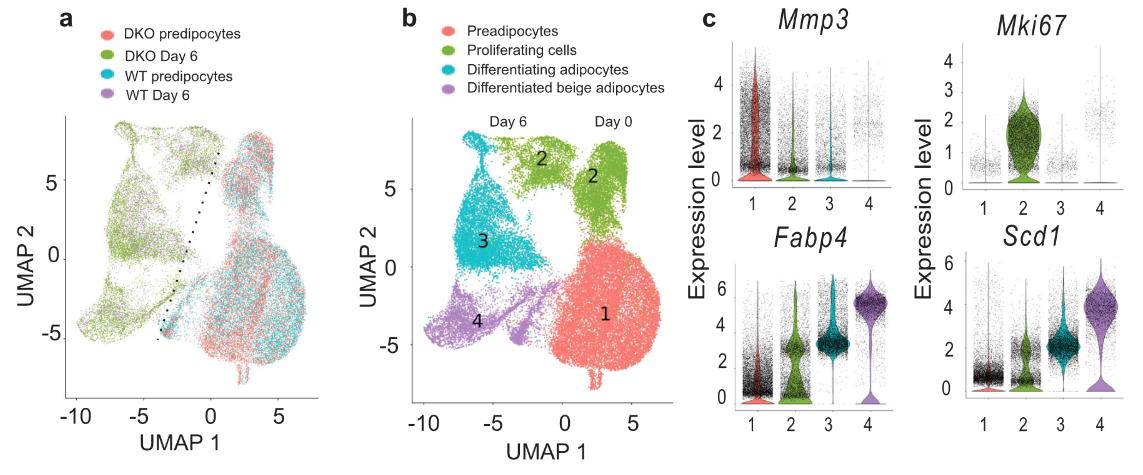



In [ ]:
#make sure we have v5 Seurat object
ko.seu <- UpdateSeuratObject(ko.seu)

##without integration
ko.seu <- RunPCA(ko.seu)
ElbowPlot(ko.seu)


In [ ]:
ko.seu <- FindNeighbors(ko.seu, dims = 1:15, reduction = "pca")
ko.seu <- FindClusters(ko.seu, resolution = 0.05, cluster.name = "unintegrated_clusters")
ko.seu <- RunUMAP(ko.seu, dims = 1:15, reduction = "pca", reduction.name = "umap.unintegrated")

In [ ]:
# visualize by sample/treatment
options(repr.plot.width=16, repr.plot.height=9)
DimPlot(ko.seu, reduction = "umap.unintegrated", group.by = c("unintegrated_clusters","time_point"))

Perform Harmony integration.

In [ ]:
#ko.seu[["RNA"]] <- JoinLayers(ko.seu[["RNA"]])
#ko.seu[["RNA"]] <- split(ko.seu[["RNA"]], f = ko.seu$time_point)
#ko.seu

In [ ]:
ko.seu <- IntegrateLayers(
  object = ko.seu, method = HarmonyIntegration,
  orig.reduction = "pca", new.reduction = "harmony",
  verbose = FALSE
)
#group.by.vars="time_point"

In [ ]:
##FOR Harmony
ko.seu <- FindNeighbors(ko.seu, reduction = "harmony", dims = 1:15)
ko.seu <- FindClusters(ko.seu, resolution = 0.05, cluster.name = "harmony_clusters")
ko.seu <- RunUMAP(ko.seu, reduction = "harmony", dims = 1:15, reduction.name = "umap.harmony")
head(ko.seu@meta.data,2)

In [ ]:
ko.seu$seurat_clusters <- ko.seu$harmony_clusters

In [ ]:
# visualize by sample/treatment
options(repr.plot.width=16, repr.plot.height=9)
DimPlot(ko.seu, reduction = "umap.harmony", group.by = c("seurat_clusters","time_point"))

Visualize the gene markers defined by the paper.

In [ ]:
#preadipocites: Mmp3; proliferating: Mki67;
#differentiating: Fabp4 (and Scd1); brown adipocytes: Scd1 (and Fabp4)
paper.genes <- c("Mmp3","Mki67","Fabp4","Scd1")

VlnPlot(ko.seu, features = paper.genes, group.by="seurat_clusters")

Save the Seurat object.

In [ ]:
saveRDS(ko.seu, file="P4/ko_adp_preprocessed_seu.Rds")

In [ ]:
ko.seu <- readRDS("P4/ko_adp_preprocessed_seu.Rds")

**6. TRAJECTORY INFERENCE WITH SLINGSHOT**


To identify a trajectory, one might imagine simply “fitting” a one-dimensional curve so that it passes through the cloud of cells in the high-dimensional expression space. This is the idea behind principal curves ([Hastie and Stuetzle 1989](https://www.tandfonline.com/doi/abs/10.1080/01621459.1989.10478797#)), effectively a non-linear generalization of PCA where the axes of most variation are allowed to bend. We use the `slingshot` package ([Street et al. 2018](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-018-4772-0)) to fit a single principal curve to the adipocyte dataset, again using the low-dimensional PC coordinates for denoising and speed. This yields a pseudotime ordering of cells based on their relative positions when projected onto the curve.


We first convert our processed Seurat object into a `SingleCellExperiment` object (SCE). Slingshot operates on `SingleCellExperiment` and uses its reduced dimensions (e.g. PCA or UMAP) and cluster labels to fit trajectories.

An SCE object stores expression matrices (`assays`), per-cell metadata (`colData`), per-gene metadata (`rowData`), and dimensionality reductions (`reducedDims`)—all in a unified structure that analysis tools like Slingshot can directly use.

In [ ]:
#first, join Layers as GetAssayData does not work for multiple layers in v5 assay
ko.seu[["RNA"]] <- JoinLayers(ko.seu[["RNA"]])
#convert to SCE
ko.sce <- as.SingleCellExperiment(ko.seu)

How to inspect your SCE.

In [ ]:
ko.sce
class(ko.sce)
dim(ko.sce)          # genes x cells
assayNames(ko.sce)   # e.g. "counts", "logcounts"

In [ ]:
#See all columns available for cells:
colnames(colData(ko.sce))
#Look at the first rows of the metadata:
head(colData(ko.sce),2)

In [ ]:
#List which reduced dimensions the object has:
reducedDimNames(ko.sce)
#Inspect a specific reduction, e.g. PCA:
head(reducedDim(ko.sce, "PCA"),2)

Slingshot infers lineages by fitting smooth curves through clusters in a low-dimensional space (typically PCA or UMAP). We must provide:

* a reduced dimension (e.g. "PCA"),

* a vector of cluster labels, and

* optionally, which cluster is the root (starting point) and which cluster(s) are terminal.
In a differentiation system, the starting cluster usually corresponds to the most progenitor-like state. In our case, we have the idea that cluster 0 correspond to the preadipocytes.

In [ ]:
set.seed(123)

ko.sling <- slingshot(
  ko.sce,
  clusterLabels = "seurat_clusters",  # colData with clusters
  reducedDim = "PCA",                # or "UMAP", "PHATE"
  start.clus = "0"                  # root cluster OPTIONAL: end.clus
)

# Slingshot adds:
# - trajectory curves/lineages (SlingshotDataSet)
# - pseudotimes (slingPseudotime)
# - weights per curve (slingCurveWeights)

In [ ]:
#saveRDS(ko.sling, file="P4/ko_sling.Rds")
ko.sling <- readRDS("P4/ko_sling.Rds")

In [ ]:
ko.sling
head(colData(ko.sling),2)

After fitting Slingshot, each cell receives a pseudotime value along each inferred lineage. We can store these pseudotime values back into the Seurat object to facilitate visualization and downstream analysis.

With slingshot, each cell gets a pseudotime per lineage. In the pseudotime matrix:
you usually see:
* Some cells have pseudotime for all lineages.
* Many cells have pseudotime for only one lineage.
* Cells not clearly assigned to a given lineage get `NA` for that lineage.

In [ ]:
#get pseudotime (matrix: cells x lineages)
pt <- slingPseudotime(ko.sling)

#how many trajectories?
head(pt,2)

#how many annotated cells per lineage?
dim(pt)
sum(is.na(pt[,"Lineage1"]))
sum(is.na(pt[,"Lineage2"]))
sum(is.na(pt[,"Lineage3"]))

In [ ]:
# 2. Convert to data.frame and ensure identical cell order
pt_df <- as.data.frame(pt)

# Very important: match cell names to Seurat object
pt_df <- pt_df[colnames(ko.seu), , drop = FALSE]

# Optional: rename columns to something nice
colnames(pt_df) <- paste0("pseudotime_lineage", seq_len(ncol(pt_df)))

# 3. Add to Seurat meta.data
ko.seu <- AddMetaData(ko.seu, metadata = pt_df)

Now `ko.seu@meta.data` has columns like `pseudotime_lineage1`, `pseudotime_lineage2`, `pseudotime_lineage3`, aligned one-to-one with the cells.

You can quickly check:

In [ ]:
colnames(ko.seu@meta.data)
summary(ko.seu@meta.data$pseudotime_lineage1)
table(is.na(ko.seu@meta.data$pseudotime_lineage1))

We can visualize pseudotime by coloring cells on the UMAP embedding. This helps us check whether the inferred trajectory follows the expected biological progression (e.g., from progenitors to mature brown adipocytes). However, some cells have `NA` pseudotime for a given lineage and this could produce some warnings and/or errors.

In [ ]:
#color UMAP by pseudotimes
FeaturePlot(
  ko.seu,
  reduction = "umap.harmony",
  features = c("pseudotime_lineage1","pseudotime_lineage2","pseudotime_lineage3"),
  pt.size = 0.5
)

As we have three lineages and we may want a single “global” pseudotime value per cell (no NAs), a common trick is to take the minimum pseudotime across lineages for each cell:

In [ ]:
pt2 <- ko.seu@meta.data[, c("pseudotime_lineage1",
                              "pseudotime_lineage2",
                              "pseudotime_lineage3")]

global_pt2 <- apply(pt2, 1, function(x) {
  if (all(is.na(x))) {
    NA_real_
  } else {
    min(x, na.rm = TRUE)
  }
})

ko.seu$global_pseudotime <- global_pt2
table(is.na(ko.seu$global_pseudotime))

In [ ]:
FeaturePlot(
  ko.seu,
  reduction = "umap.harmony",
  features = "global_pseudotime",
  pt.size = 0.5
) + scale_color_viridis_c(option = "plasma")

Now we want to visualize the trajectories in the UMAP.

In [ ]:
# UMAP coordinates from Seurat
umap_df <- Embeddings(ko.seu, "umap.harmony") %>%
  as.data.frame()

umap_df$cell <- rownames(umap_df)

# Example: use a global pseudotime stored in Seurat metadata
# (adapt this to your object, e.g. ko.seu$global_pseudotime or any other column)
umap_df$shared_pseudo <- ko.seu$global_pseudotime[umap_df$cell]

p_umap <- ggplot(umap_df, aes(umapharmony_1, umapharmony_2, colour = shared_pseudo)) +
  geom_point(size = 0.5) +
  scale_colour_viridis_c(option = "plasma") +
  theme_classic() +
  labs(
    title = "UMAP with Slingshot trajectories",
    colour = "pseudotime"
  )

In [ ]:
head(umap_df,2)

In [ ]:
p_umap

Get the Slingshot curves and overlay them on the Seurat UMAP.

The key trick: Slingshot’s curves live in the SCE space, where UMAP columns are often "UMAP1", "UMAP2", whereas Seurat’s reduction uses "UMAP_1", "UMAP_2", "umapharmony_1" and "umapharmony_2" in this case. We just rename columns to match.

`embedCurves` projects the smoothed lineages (the principal curves) into the "UMAP" space. It also stores this curve information internally so that `slingCurves(embedded)` knows how to access curve coordinates in UMAP1/UMAP2.

In [ ]:
# Embed curves in the UMAP space
embedded <- embedCurves(ko.sling, "UMAP.HARMONY")
curves <- slingCurves(embedded)
class(curves)
length(curves)
head(curves[[1]]$s)      # coordinates of the smooth curve
head(curves[[1]]$lambda) # pseudotime per cell for this lineage
head(curves[[1]]$w)      # lineage weights per cell


In [ ]:
# Add each trajectory curve to the Seurat-based UMAP

# gg_curves starts from your Seurat UMAP plot
gg_curves <- p_umap   # this is your ggplot with the cells already plotted

# curves is what you got from slingCurves(...)

for (i in seq_along(curves)) {
  curve_i <- curves[[i]]

  # For principal_curve objects, use $s and $ord
  curve_df <- as.data.frame(
    curve_i$s[curve_i$ord, c("umapharmony_1", "umapharmony_2")]
  )

  # Make sure column names match what p_umap expects
  colnames(curve_df) <- c("umapharmony_1", "umapharmony_2")

  gg_curves <- gg_curves +
    geom_path(
      data = curve_df,
      aes(x = umapharmony_1, y = umapharmony_2),
      inherit.aes = FALSE,
      linewidth = 1.2
    )
}

gg_curves


**7. Downstream analysis DO NOT RUN!!!**  

To identify genes whose expression changes smoothly along pseudotime, we can fit generalized additive models (GAMs) using packages like `tradeSeq`. These models test whether a gene’s expression is significantly associated with pseudotime while accounting for trajectory structure.

In [ ]:
##get gene counts (genes x cells)
cts <- as.matrix(counts(ko.sling))

##get pseudotimes and weights from Slingshot
pt <- slingPseudotime(ko.sling)        # matrix: cells x lineages
w  <- slingCurveWeights(ko.sling)      # matrix: cells x lineages

In [ ]:
head(pt,2)

In [ ]:
##select main lineage
lineage <- 1

pt1 <- pt[, lineage, drop = FALSE]     # pseudotime for Lineage1
w1  <- w[, lineage, drop = FALSE]      # weights for Lineage1

##keep only those cells with valid pseudotime and weight>0
keep_cells <- which(!is.na(pt1[, 1]) & w1[, 1] > 0)  # puedes quitar el & w1... si no quieres filtrar por peso

length(keep_cells)        # number of filtered cells
length(colnames(cts))     # total cells

In [ ]:
##subset counts, pseudotime and weights for valid cells
cts_use <- cts[, keep_cells]
pt_use  <- pt1[keep_cells, , drop = FALSE]
w_use   <- w1[keep_cells, , drop = FALSE]

Fit GAM for Lineage1 and plot.

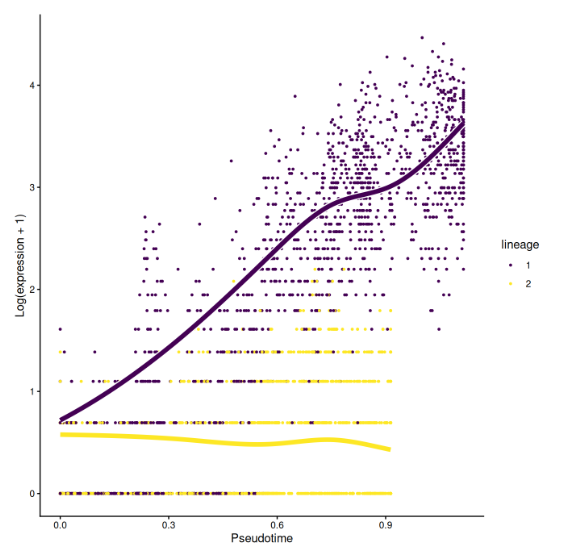

In [ ]:
set.seed(123)

sce_gam <- fitGAM(
  counts      = cts_use,
  pseudotime  = pt_use,   # only Lineage1
  cellWeights = w_use,    # only Lineage1
  nknots      = 6,
  verbose     = TRUE
)

In [ ]:
## Test de asociación con pseudotime
assoRes <- associationTest(sce_gam)    # con un solo linaje ya es test "a lo largo del pseudotiempo"
assoRes$gene <- rownames(assoRes)

## Genes más significativos
topGenes <- assoRes %>%
  arrange(pvalue) %>%
  head(20) %>%
  pull(gene)

gene_of_interest <- topGenes[1]

plotSmoothers(
  sce     = adipo.sub,
  counts  = cts_use,
  gene    = gene_of_interest,
  nPoints = 100
)

**8. EXERCISE**

**Please submit a Google Colab notebook with your implementation of this exercise, ideally refining the QC filters, testing alternative integration options and cell type annotation, and removing very small clusters before running the trajectory analysis on the main populations only. Make sure to comment on your results with a biologically grounded interpretation. You may also reflect on how your preprocessing choices affected the final trajectories.**